# SCRIPT FUNCTION

- requires pre-epoched data  
- combines separate epoch files from each session into a single dataset
- power spectra 
- time frequency analysis of epoch segments
- comaprison of high vs low brain states

In [1]:
#LOAD MODULES
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import signal
from random import randrange
from numpy import shape as s
import mne
import os
import sys
os.chdir(r'C:\Users\rhyso\eegdata')
import mbp

#LOAD DATA
all_epochs = mne.read_epochs('all_epochs_GW-epo.fif', preload= True)

Reading all_epochs_GW-epo.fif ...
    Found the data of interest:
        t =  -20000.00 ...   30000.00 ms
        0 CTF compensation matrices available
94 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


94 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


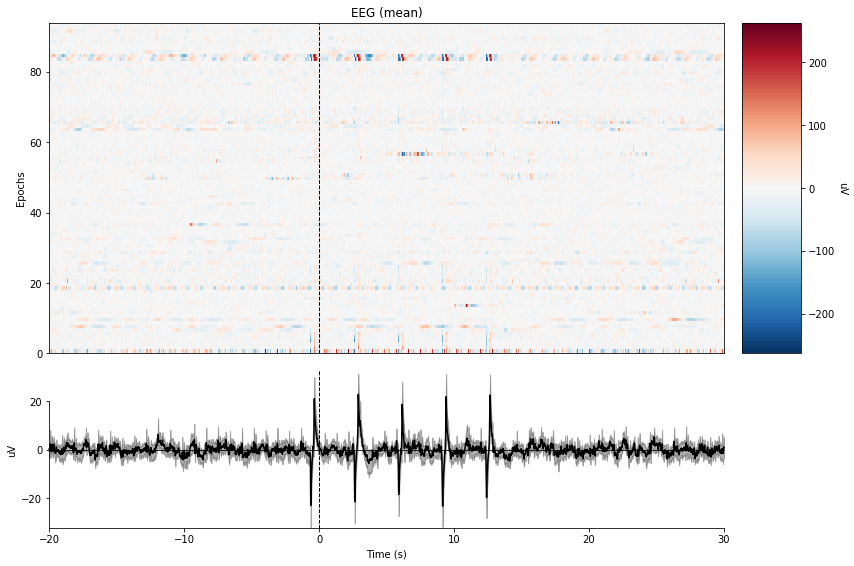

In [5]:
#Plot a graph of EEG signal over time. Each epoch visualised individually on y axis and average displayed separately. 
fig = plt.rcParams["figure.figsize"]= [12, 8]
fig = mne.Epochs.plot_image(all_epochs, combine='mean')
plt.show()

N.o. chans 5
N.o. epochs 94
N.o. freqs 139


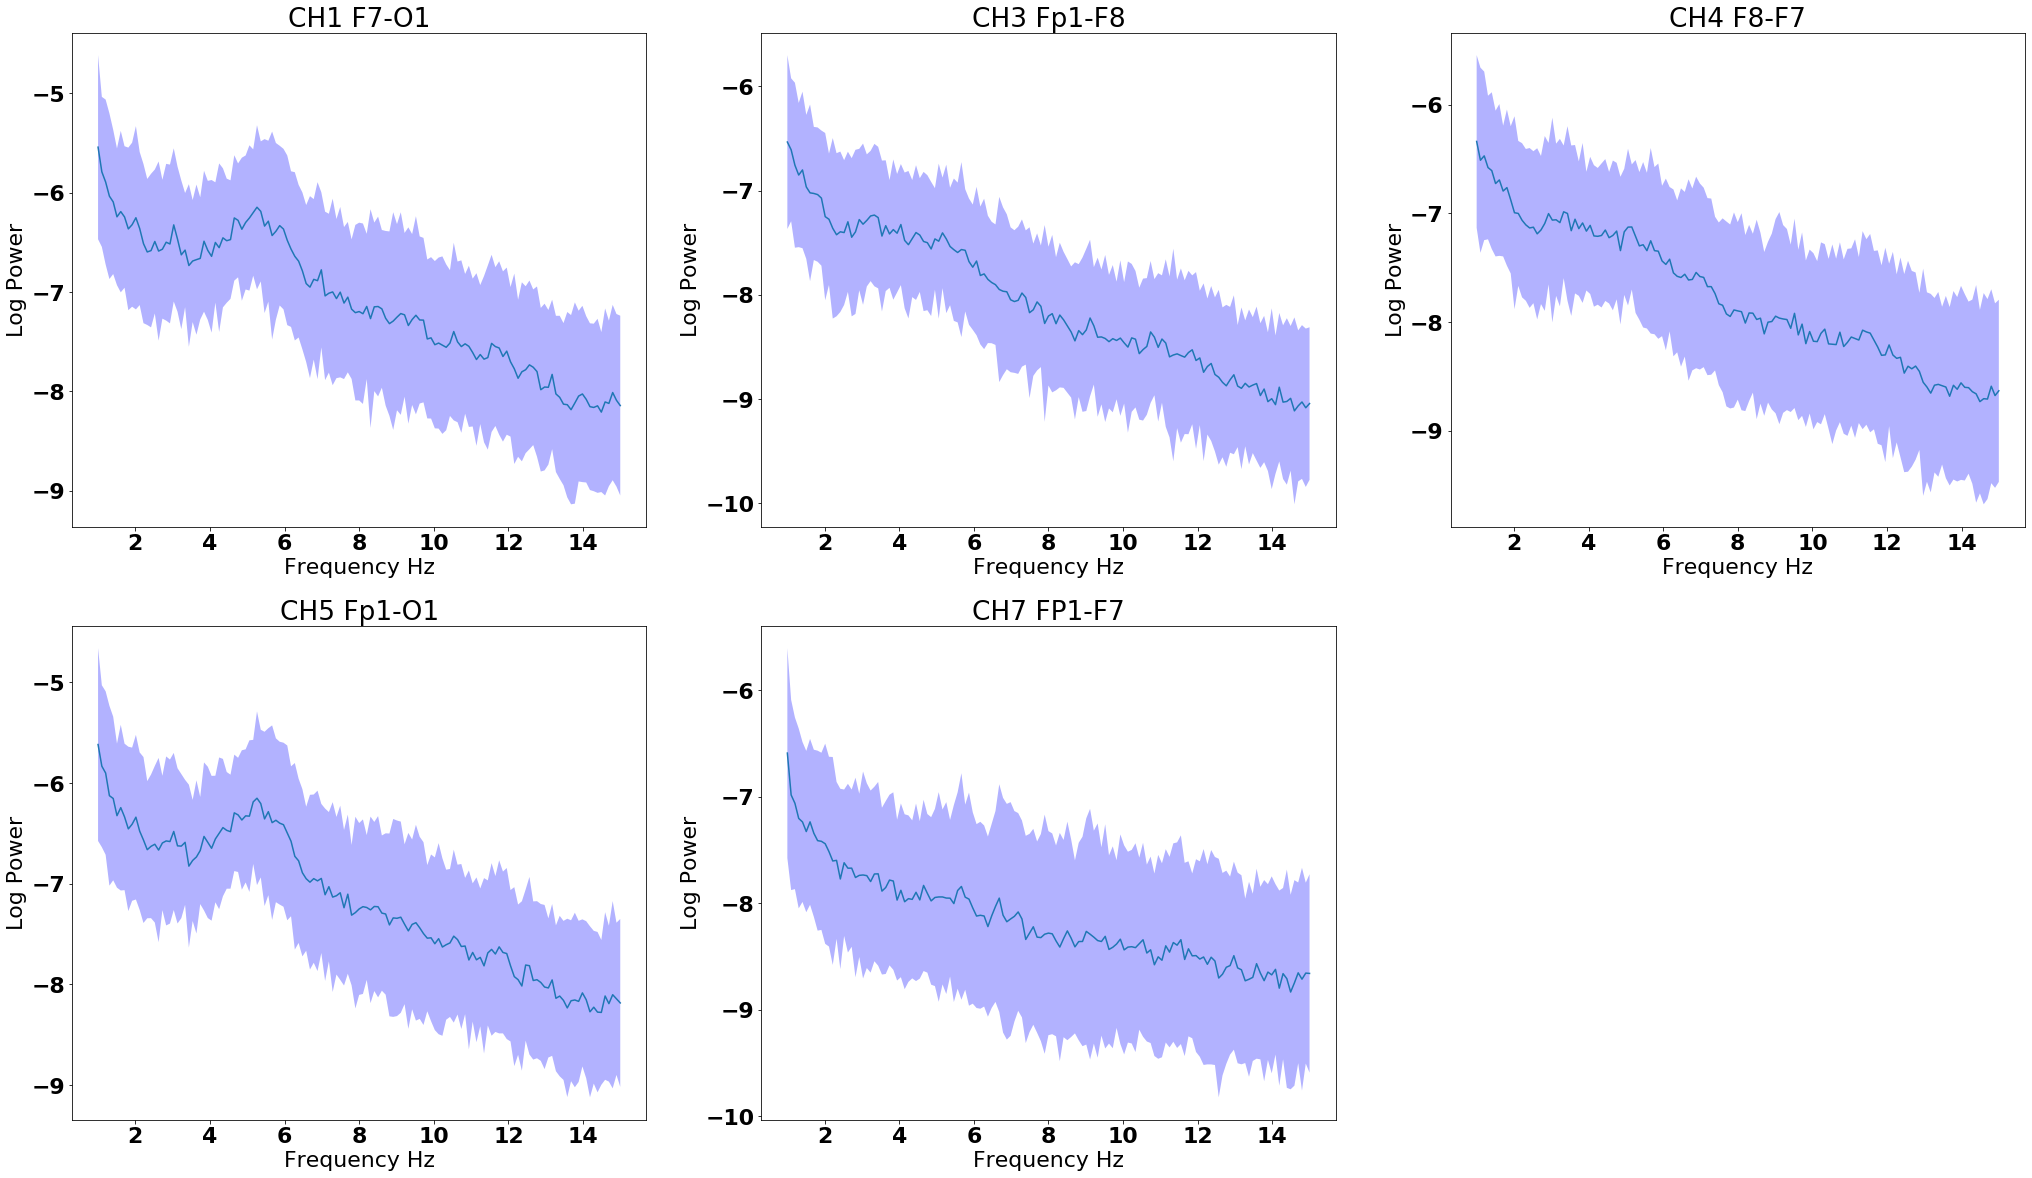

In [7]:
# GENERATE RESTING STATE POWER SPECTRA (MBP CODE)

# Generate np array with only baseline segments
base_epochs = mne.Epochs.copy(all_epochs)
base_epochs = mne.Epochs.crop(base_epochs, tmin = -19, tmax = -4)
base_epochs = mne.Epochs.get_data(base_epochs)
base_epochs.shape

#initialise 
dft_freqs = np.arange(1, 15, 0.1) # select frequencies of interest
base_dft = np.zeros((base_epochs.shape[1], base_epochs.shape[0], len(dft_freqs)-1)) # create empty dft array (nchans, nepochs,
#nfreq)

#iterate through channels and calculate dft
for i in range(base_epochs.shape[1]):
    base_dft[i,:,:] = np.squeeze(mbp.mbp(base_epochs[:,i,:], freqs = dft_freqs, fs = 250)) 
    
# check expected dimensions
print('N.o. chans', base_dft.shape[0])
print('N.o. epochs', base_dft.shape[1])
print('N.o. freqs', base_dft.shape[2])

#for each channel, plot power spectra for the 4 conditions
font = {'weight' : 'bold',
        'size'   : 22}
adj_freqs = np.linspace(1, 15, num = len(dft_freqs)-1) # true length of dft frequencies  = dft_freqs - 1
plt.figure( figsize = (35,20))
plt.rc('font', **font)
for i in range(base_dft.shape[0]):
    plt.subplot(2,3,i+1)
    avg_power = np.mean(base_dft[i,:,:], axis = 0)
    base_error = np.std(base_dft[i,:,:], axis = 0)
    plt.plot(adj_freqs, avg_power)
    plt.fill_between(adj_freqs, avg_power - base_error, avg_power + base_error, facecolor = 'b', alpha=0.3)
    plt.title(all_epochs.ch_names[i])
    plt.xlabel('Frequency Hz')
    plt.ylabel('Log Power')
plt.show()


In [8]:
#TIME FREQUENCY ANALYSIS

import mne.time_frequency as tf 

# Extraction of numpy array from epoch data is required. This is because the mne.STFT function requires an input with the 
# shape: (n_signals, n_timepoints) and therefore requires each epoch to analysed separately.
np_epochs = mne.Epochs.get_data(all_epochs)
dim_check = np_epochs.shape
print('Epoch time series: The number of epochs is:', dim_check[0])
print('Epoch time series: The number of eeg channels is:', dim_check[1])
print('Epoch time series: The number of timepoints per epoch is:', dim_check[2])

# CALCULATE STFT DIMENSIONS
window_width = 400 # trade off between time and freq resolution. Increase value to increase frequency resolution
test_stft = tf.stft(np_epochs[0,:,:], wsize = window_width, tstep = None, verbose = None)
stft_dim = [test_stft.shape[0], test_stft.shape[1], test_stft.shape[2]] 
stft_freqs = tf.stftfreq(window_width, sfreq = 250) # list of frequencies in Hz
stft_times = np.linspace(start = -20, stop = 30, num = stft_dim[2]) # list of timepoints in seconds 
print('STFT: the number of channels is', stft_dim[0])
print('STFT: the number of frequencies is', stft_dim[1])
print('STFT: the number of timepoints is', stft_dim[2])

#CALCULATE STFT FOR ALL EPOCHS THEN AVERAGE

cmb_stft = np.zeros((dim_check[0], stft_dim[0], stft_dim[1], stft_dim[2])) #Generate empty 4D array with appropriate shape

#iterate through epochs and calculate stft
for i in range(dim_check[0]):
    ind_epoch = np_epochs[i,:,:]
    cmb_stft[i,:,:,:] = tf.stft(ind_epoch, wsize = window_width, tstep = None, verbose = None)
    
cmb_stft = np.abs(cmb_stft) # take absolute values, only phase info lost
cmb_stft = np.mean(cmb_stft, axis = 0) # average across epoch dimension

# STORE DATA IN AN MNE FORMAT 
tfr = tf.AverageTFR(info = all_epochs.info, data = cmb_stft, nave = dim_check[0], freqs = stft_freqs, times = stft_times,
                    verbose = None) 


Epoch time series: The number of epochs is: 94
Epoch time series: The number of eeg channels is: 5
Epoch time series: The number of timepoints per epoch is: 12501
Number of frequencies: 201
Number of time steps: 63
STFT: the number of channels is 5
STFT: the number of frequencies is 201
STFT: the number of timepoints is 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63

C:\Users\rhyso\anaconda3\lib\site-packages\ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of frequencies: 201
Number of time steps: 63
Number of fr

Applying baseline correction (mode: logratio)


<Figure size 1080x360 with 0 Axes>

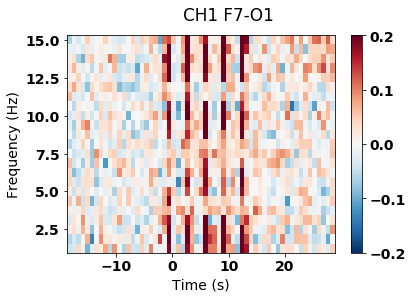

Applying baseline correction (mode: logratio)


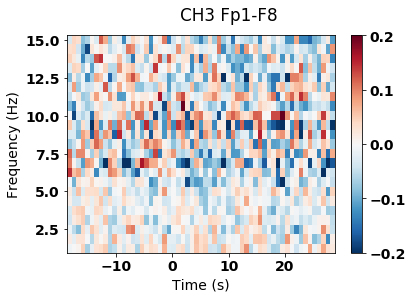

Applying baseline correction (mode: logratio)


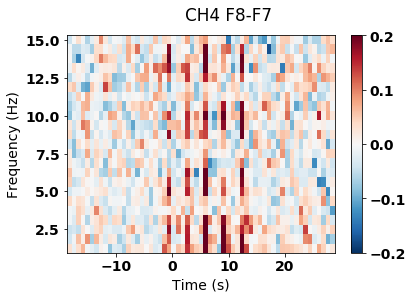

Applying baseline correction (mode: logratio)


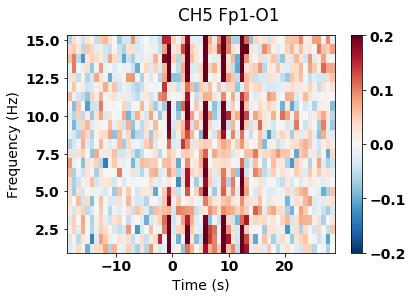

Applying baseline correction (mode: logratio)


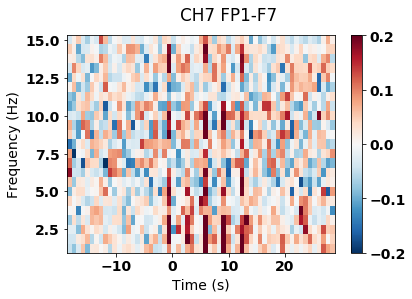

In [11]:
#PLOT TIME FREQUENCY REPRESENTATIONS
plt.figure( figsize = (15,5))
font = {'size'   : 14}
plt.rc('font', **font)
for i in range(cmb_stft.shape[0]):
    tf.AverageTFR.plot(tfr, baseline = [-19, -4], mode = 'logratio', fmin = 1, fmax = 15, tmin = -19, 
                   tmax = 29, vmin = -0.2, vmax = 0.2, picks = tfr.ch_names[i])

N.o. chans 5
N.o. epochs 94
N.o. freqs 139


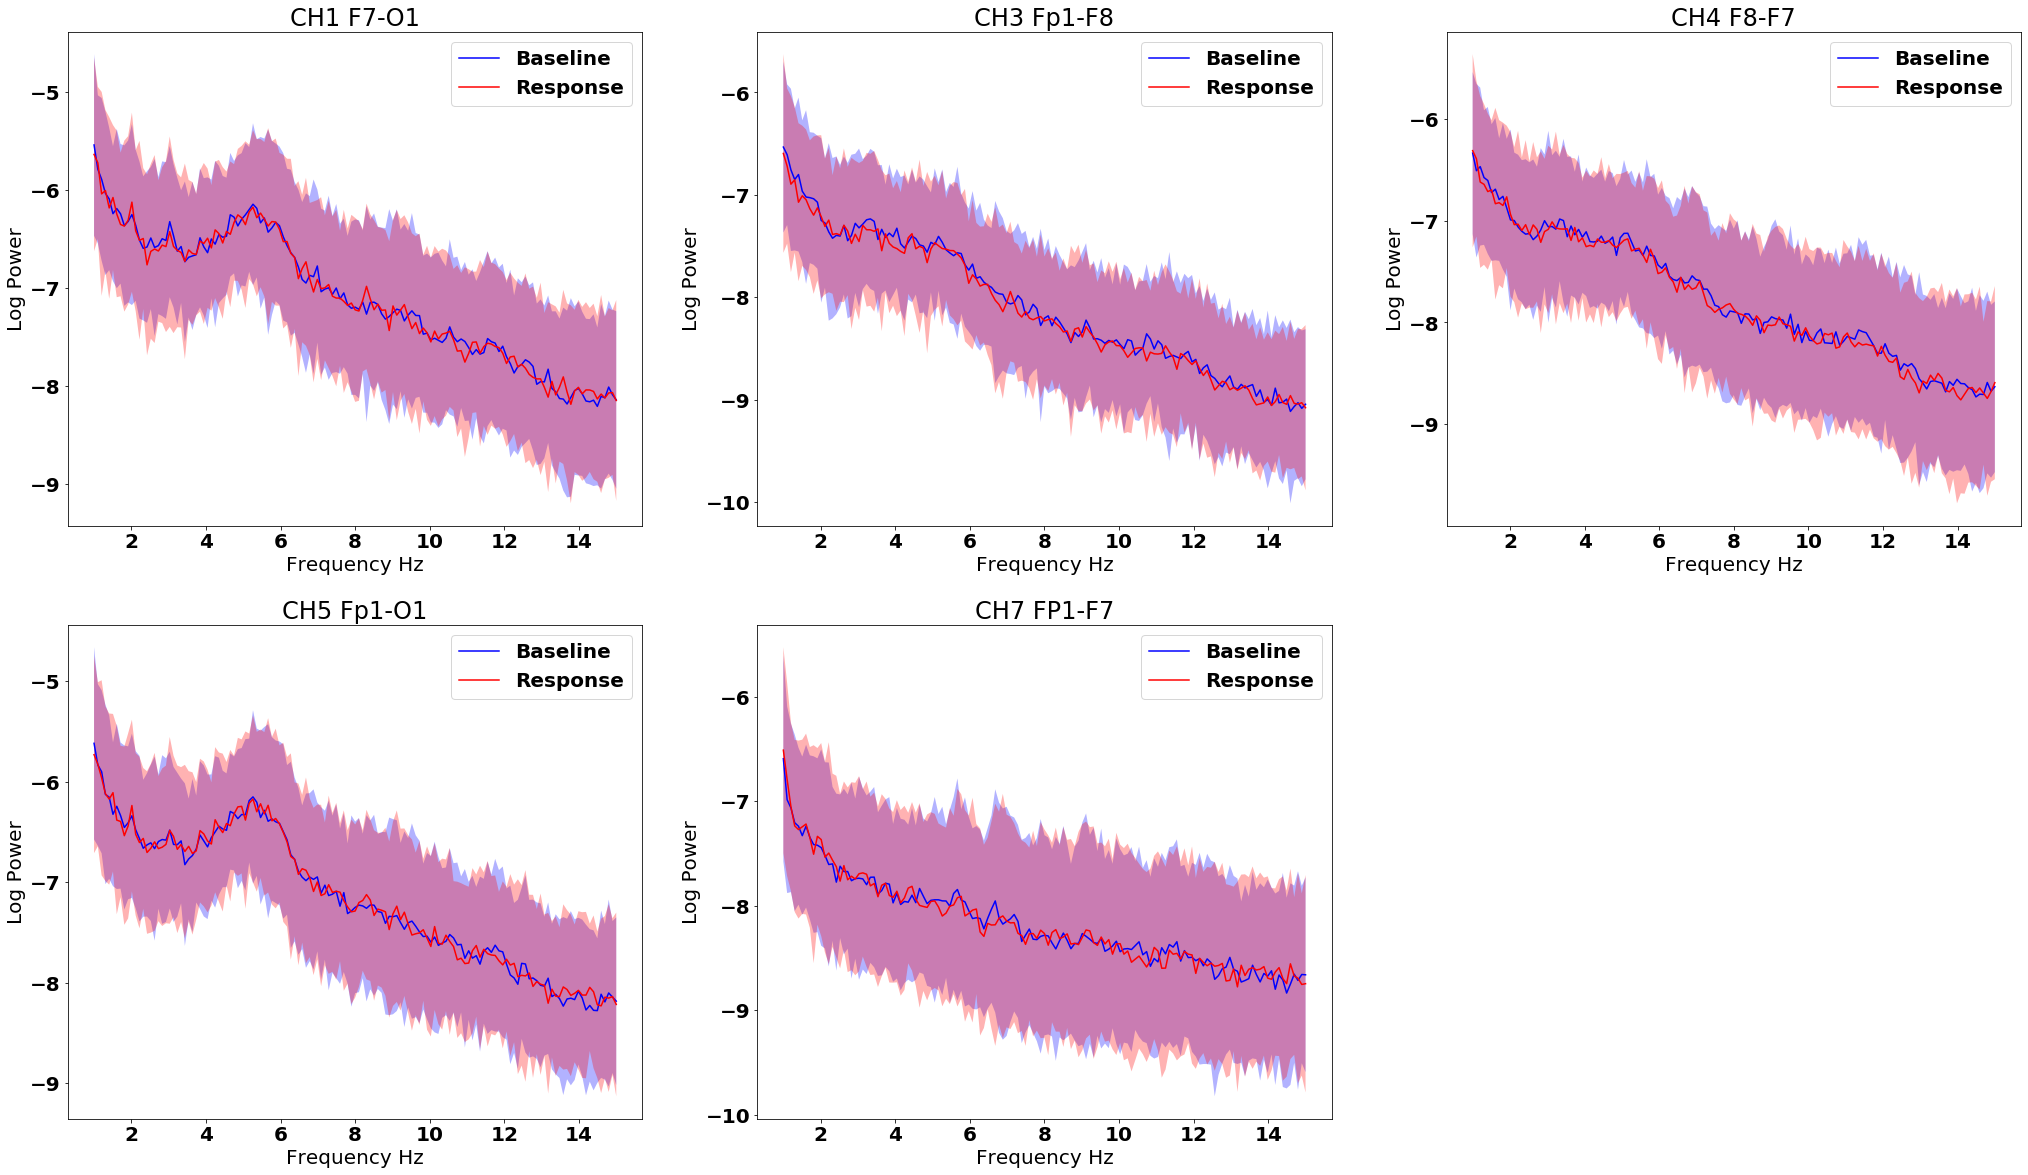

In [14]:
# POWER SPECTRA BEFORE AND AFTER STIMULI

#extract response segment
resp_epochs = mne.Epochs.copy(all_epochs)
resp_epochs = mne.Epochs.crop(resp_epochs, tmin = 14, tmax = 29) # response period 14s to 29s after stimulus train
resp_epochs = mne.Epochs.get_data(resp_epochs)

resp_dft = np.zeros((resp_epochs.shape[1], resp_epochs.shape[0], len(dft_freqs)-1)) # create empty dft array (nchans, nepochs,
#nfreq)

#iterate through channels and calculate dft
for i in range(resp_epochs.shape[1]):
    resp_dft[i,:,:] = np.squeeze(mbp.mbp(resp_epochs[:,i,:], freqs = dft_freqs, fs = 250)) 
    
# check expected dimensions
print('N.o. chans', resp_dft.shape[0])
print('N.o. epochs', resp_dft.shape[1])
print('N.o. freqs', resp_dft.shape[2])

# Plot power spectra baseline vs response
ps_labels = ['Baseline', 'Response']
plt.figure( figsize = (35,20))
font = {'size'   : 20}
plt.rc('font', **font)
for i in range(base_dft.shape[0]):
    plt.subplot(2,3,i+1)
    avg_base = np.mean(base_dft[i,:,:], axis = 0)
    base_error = np.std(base_dft[i,:,:], axis = 0)
    plt.plot(adj_freqs, avg_base, label = ps_labels[0], color = 'b')
    plt.fill_between(adj_freqs, avg_base - base_error, avg_base + base_error, facecolor = 'b', alpha=0.3)
    avg_resp = np.mean(resp_dft[i,:,:], axis = 0)
    resp_error = np.std(resp_dft[i,:,:], axis = 0)
    plt.plot(adj_freqs, avg_resp, label = ps_labels[1], color = 'r')
    plt.fill_between(adj_freqs, avg_resp - resp_error, avg_resp + resp_error, facecolor = 'r', alpha=0.3)
    plt.title(all_epochs.ch_names[i])
    plt.xlabel('Frequency Hz')
    plt.ylabel('Log Power')
    plt.legend(loc = 'upper right')
plt.show()


N.o freqs within brain rhythm  0 :  1
N.o freqs within brain rhythm  1 :  6
N.o freqs within brain rhythm  2 :  15
N.o freqs within brain rhythm  3 :  5


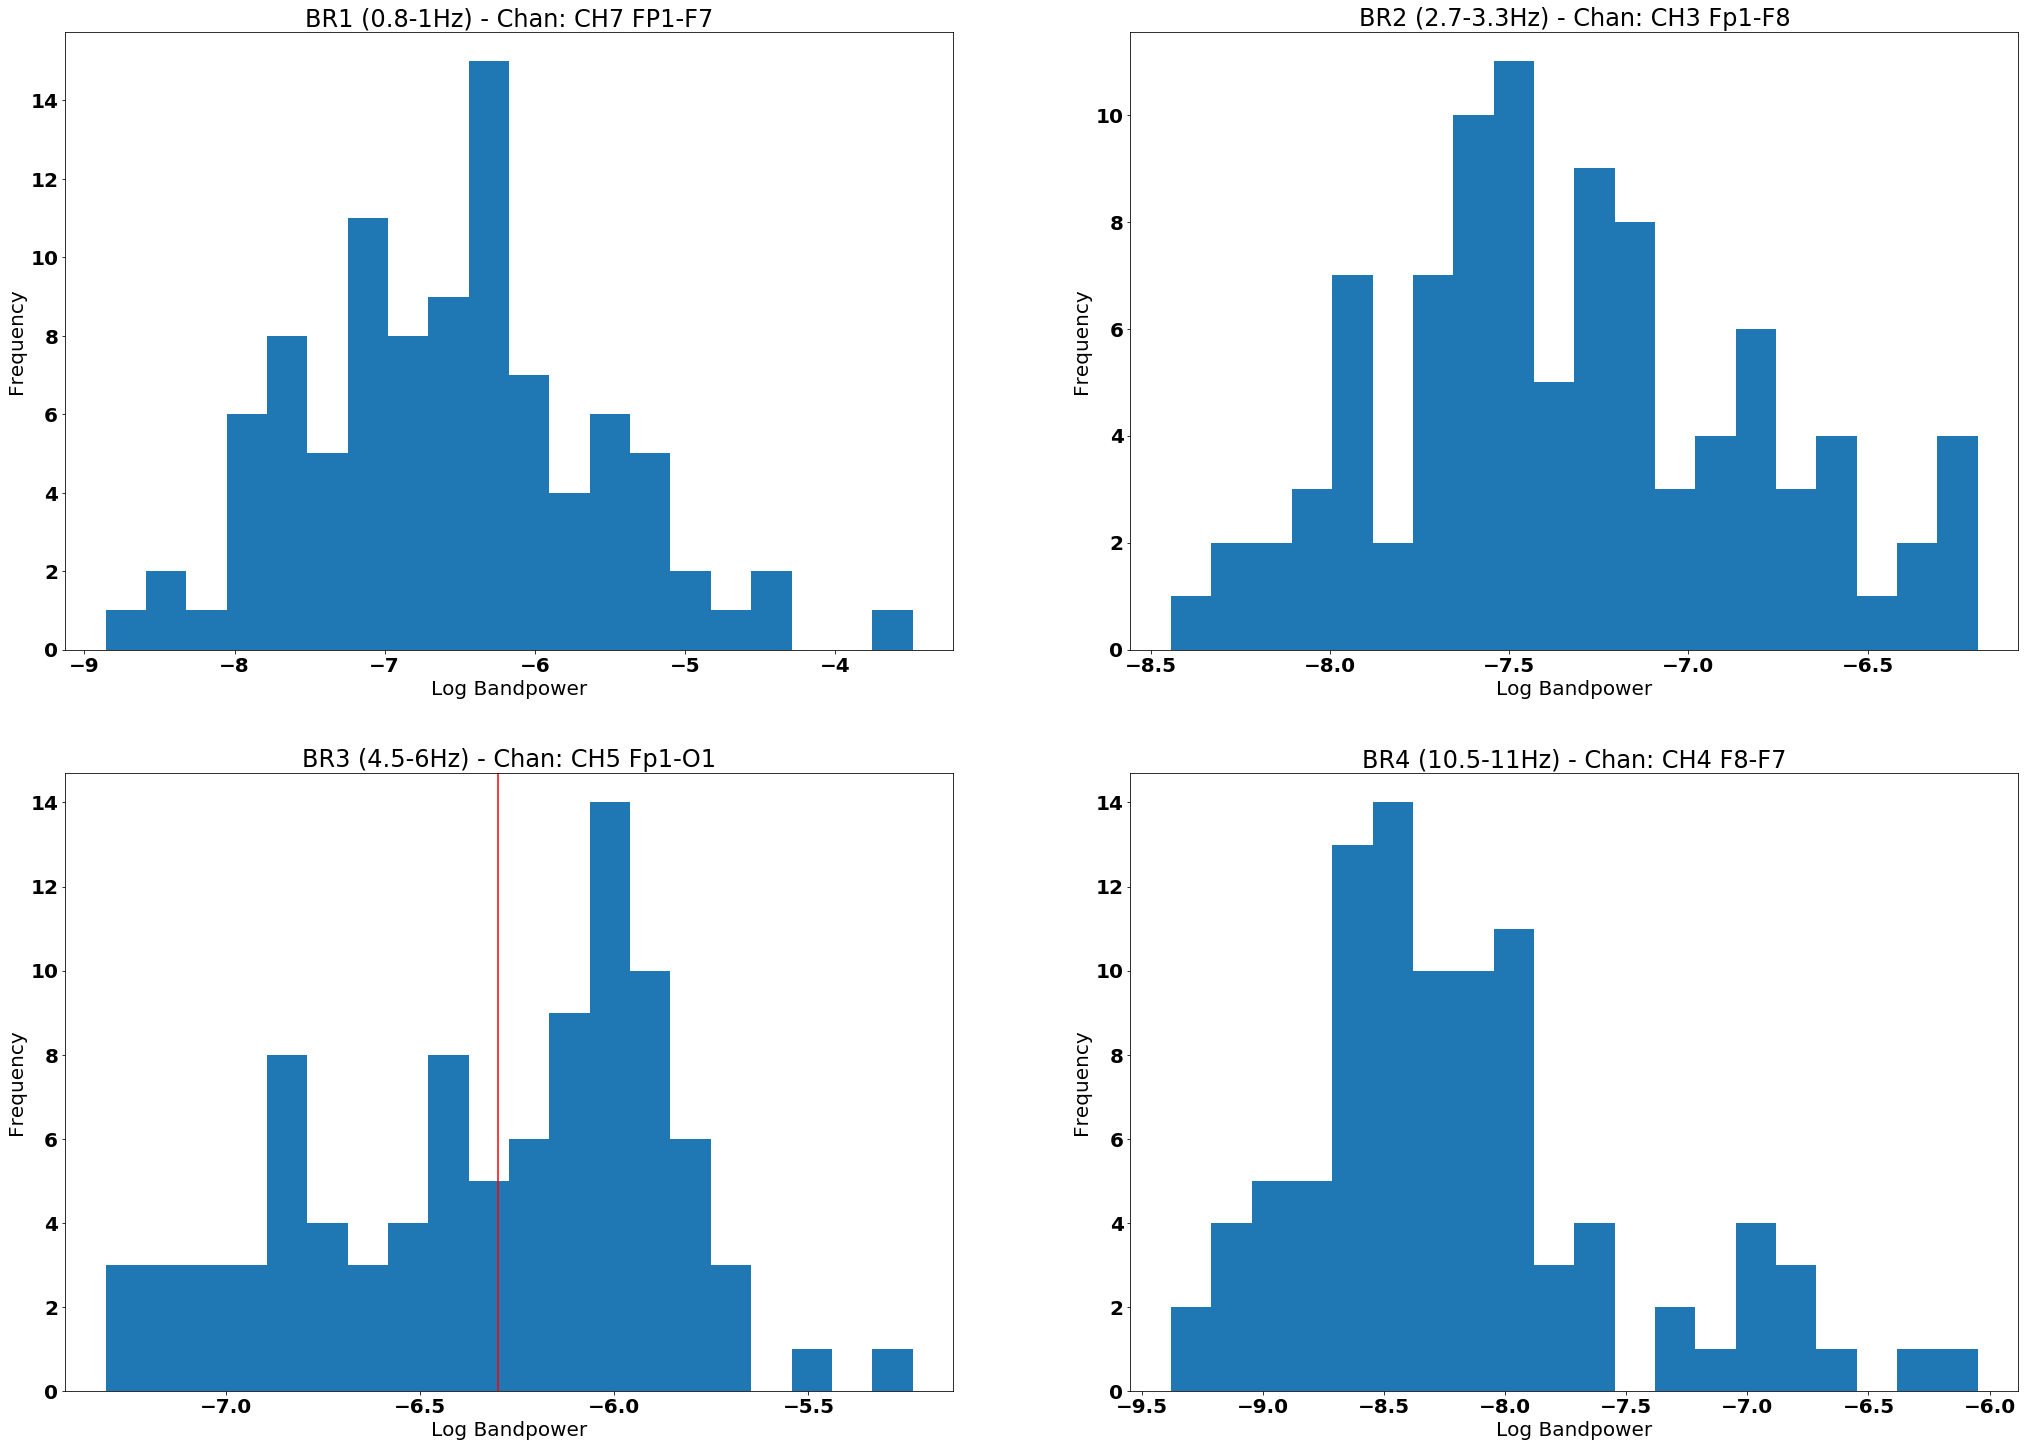

The number of high brain state epochs: 51
The number of low brain state epochs: 43


In [36]:
# BRAIN RHYTHM ANALYSIS

#initialise
br_lim = [[0.8,1], [2.7,3.3], [4.5,6], [10.5,11]]  # freq limits for each brain rhythm
br_chan = [4, 1, 3, 2] # indices of good channels
br_title = ['BR1 (0.8-1Hz)', 'BR2 (2.7-3.3Hz)', 'BR3 (4.5-6Hz)', 'BR4 (10.5-11Hz)']
br_avg = np.zeros((len(br_chan), base_dft.shape[1])) # create empty array with dimensions: n_chans, n_epochs

for i in range(len(br_chan)): # iterate through chans with brain rhythms
    br_freqs = np.where((adj_freqs >= br_lim[i][0]) & (adj_freqs <= br_lim[i][1]))[0]
    print('N.o freqs within brain rhythm ',i,': ', len(br_freqs))
    for j in range(base_dft.shape[1]): # iterate through epochs
        br_avg[i,j] = np.mean(base_dft[br_chan[i], j, br_freqs], axis = 0)


# Plot histograms of avg power across epochs for each brain rhythm
plt.figure( figsize = (35,25))
thresh = -6.30
for i in range(len(br_chan)):  
    plt.subplot(2,2,i+1)
    plt.hist(br_avg[i], bins = 20)
    plt.title(br_title[i] + ' - Chan: '+ all_epochs.ch_names[br_chan[i]])
    plt.xlabel('Log Bandpower')
    plt.ylabel('Frequency')
    if i == 2:
        plt.axvline(x= thresh, color = 'r')
    else:
        pass
plt.show()


#identify epoch indices corresponding to high and low brain states

thresh = -6.30 # set threshold log power value which separates high/low brain state 

high_index = np.where(br_avg[2,:] > thresh)[0] # indices of high brain state epochs
print('The number of high brain state epochs:', len(high_index))
low_index = np.where(br_avg[2,:] <= thresh)[0] # indices of low brain state epochs
print('The number of low brain state epochs:', len(low_index))

Same number of epochs in each condition?  True
Number of epochs per condition:  43


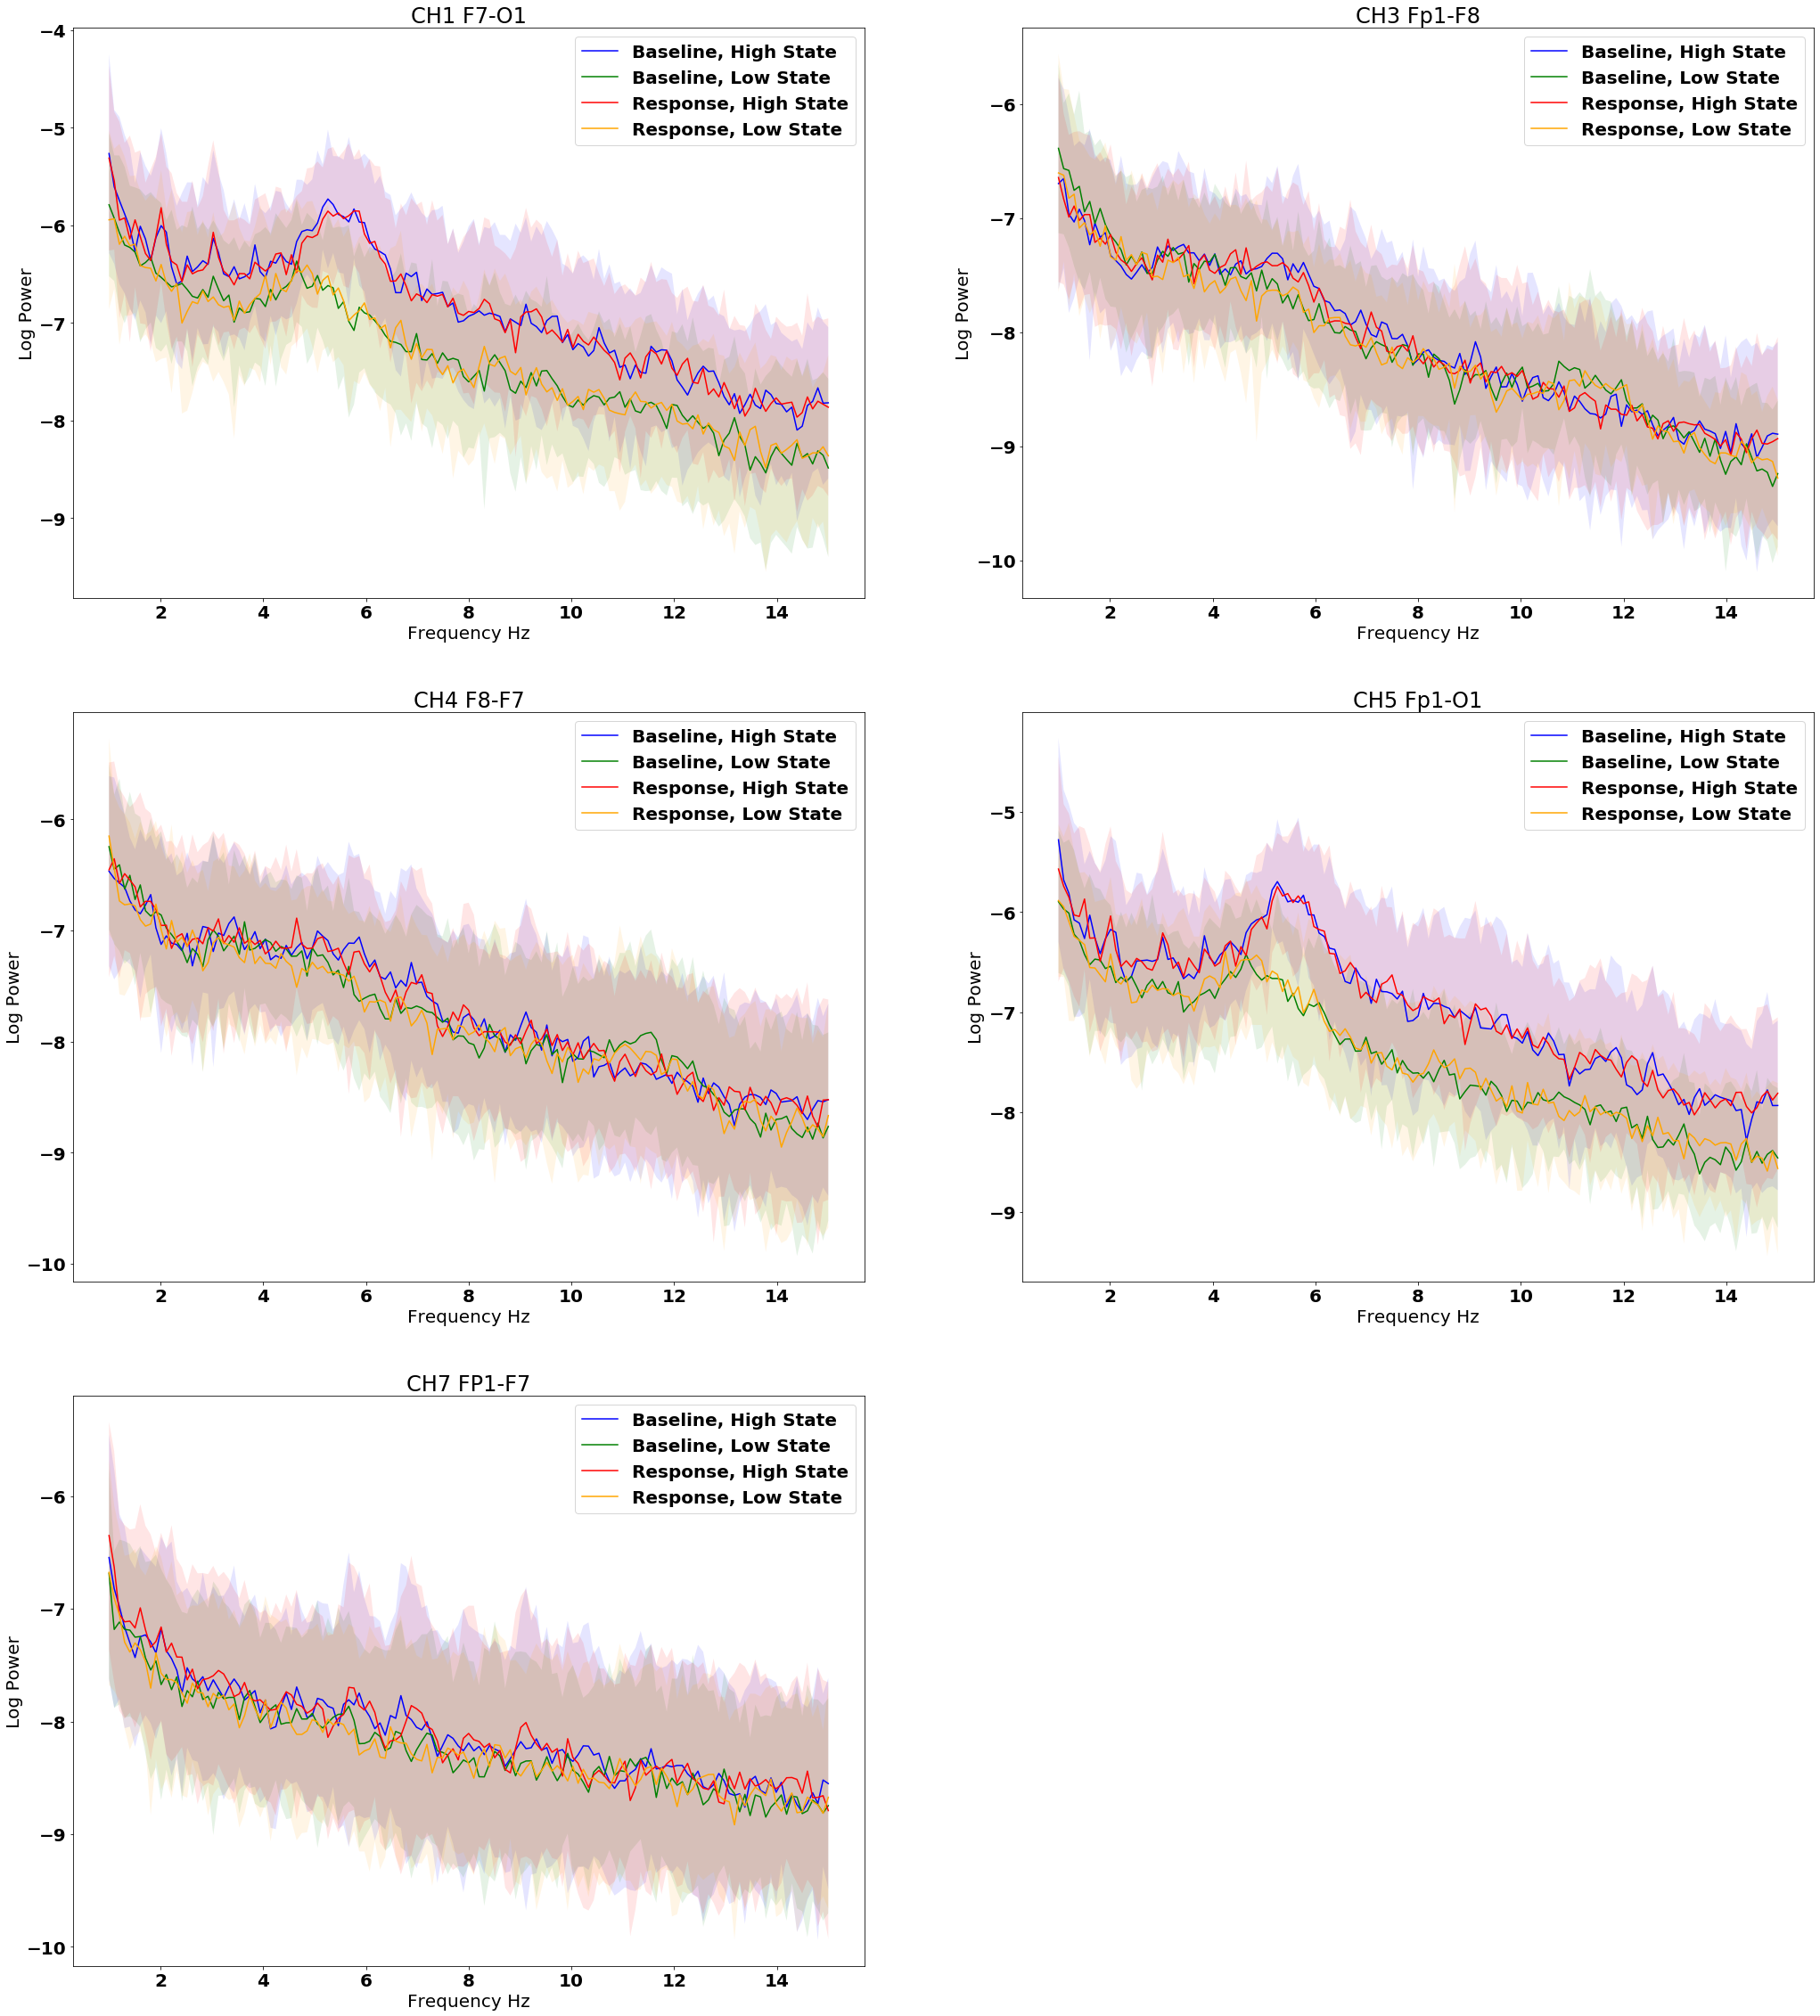

In [37]:
# PLOT POWER SPECTRA: HIGH VS LOW BRAIN STATE & BASELINE VS RESPONSE

# Equalise number of low vs high brain state epochs used

high_count = len(high_index)
low_count = len(low_index)

if high_count > low_count: 
    adj_high = np.random.choice(high_index, size = low_count, replace = False)
    adj_low = low_index
elif high_count < low_count:
    adj_low = np.random.choice(low_index, size = high_count, replace = False)
    adj_high = high_index
else: 
    pass 

print('Same number of epochs in each condition? ', len(adj_low) == len(adj_high)) # sanity check
print('Number of epochs per condition: ', len(adj_low))

#for each channel, plot power spectra for the 4 conditions
adj_freqs = np.linspace(1, 15, num = 139) # true length of dft frequencies  = dft_freqs - 1
plt.figure( figsize = (35,40))
for i in range(base_dft.shape[0]):
    plt.subplot(3,2,i+1)
    #baseline, high state
    avg_bh = np.mean(base_dft[i, adj_high, :], axis = 0)
    error_bh = np.std(base_dft[i, adj_high, :], axis = 0)
    plt.plot(adj_freqs, avg_bh, color = 'b', label = 'Baseline, High State')
    plt.fill_between(adj_freqs, avg_bh - error_bh, avg_bh + error_bh, facecolor = 'b', alpha=0.1)
    #baseline, low state
    avg_bl = np.mean(base_dft[i, adj_low, :], axis = 0)
    error_bl = np.std(base_dft[i, adj_low, :], axis = 0)
    plt.plot(adj_freqs, avg_bl, color = 'g', label = 'Baseline, Low State')
    plt.fill_between(adj_freqs, avg_bl - error_bl, avg_bl + error_bl, facecolor = 'g', alpha=0.1)
    #response, high state
    avg_rh = np.mean(resp_dft[i, adj_high, :], axis = 0)
    error_rh = np.std(resp_dft[i, adj_high, :], axis = 0)
    plt.plot(adj_freqs, avg_rh, color = 'r', label = 'Response, High State')
    plt.fill_between(adj_freqs, avg_rh - error_rh, avg_rh + error_rh, facecolor = 'r', alpha=0.1)
    #response, low state
    avg_rl = np.mean(resp_dft[i, adj_low, :], axis = 0)
    error_rl = np.std(resp_dft[i, adj_low, :], axis = 0)
    plt.plot(adj_freqs, avg_rl, color = 'orange', label = 'Response, Low State')
    plt.fill_between(adj_freqs, avg_rl - error_rl, avg_rl + error_rl, facecolor = 'orange', alpha=0.1)
    #axes
    plt.title(all_epochs.ch_names[i])
    plt.xlabel('Frequency Hz')
    plt.ylabel('Log Power')
    plt.legend(loc = 'upper right', prop={'size': 20})
plt.show()


[2.72 2.83 2.93 3.03 3.13 3.23]  Frequencies
[0.75  0.145 0.709 0.863 0.181 0.674]  tstatS


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

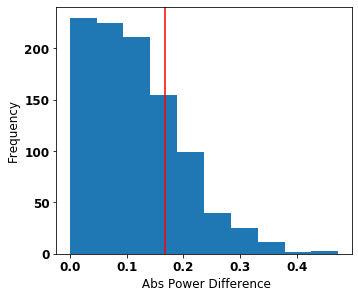

In [90]:
# PERMUTATION STATISTICS

# Goal: investigate potential differences in power values between baseline and response segments 
# (separately for low and high brain state epochs)

# Brain Rhythm 2 (2.7-3.3 Hz) Chan 3 FP1-F8

br_freqs = np.where((adj_freqs >= 2.7) & (adj_freqs <= 3.3))[0]
perm_num = 1000
sample_diff = np.zeros((len(br_freqs), perm_num))
real_diff = np.zeros(len(br_freqs))
abs_diff = np.zeros(len(br_freqs))
tstat = np.zeros(len(br_freqs))
count = np.zeros(perm_num)

for i in range(len(br_freqs)): # iterate across freqs
    real_diff[i] = np.mean(base_dft[1, adj_low, br_freqs[i]], axis=0) - np.mean(resp_dft[1, adj_low, br_freqs[i]], axis=0)
    abs_diff[i] = np.abs(real_diff[i])
    sample_low = np.concatenate((base_dft[1, adj_low, br_freqs[i]], resp_dft[1, adj_low, br_freqs[i]]), axis = 0) 
    
    for j in range(perm_num): # iterate across permutations
        np.random.shuffle(sample_low)
        sample_base, sample_resp = np.split(sample_low, 2)
        sample_diff[i,j] = np.abs(np.mean(sample_base) - np.mean(sample_resp))
        
        # label permutations based on whether the real difference exceeds sample difference
        if sample_diff[i,j] < abs_diff[i]:
            count[j] = 1
            
        elif sample_diff[i,j] >= abs_diff[i]:
            count[j] = 0 
        
        #calcuate t statistic as the proportion of random sample test differences which exceeded actual difference divided
        #by the total number of permutations
        tstat[i] = np.sum(count)/perm_num 

freq_label = np.around(adj_freqs[br_freqs], decimals = 2)
print(freq_label, ' Frequencies')
print(tstat, ' tstatS')


for i in range(len(freq_label)):
    freq_label[i] = np.str(freq_label[i])

plt.figure( figsize = (18,10))
font = {'size'   : 12}
plt.rc('font', **font)
for i in range(len(br_freqs)):   
    plt.subplot(2,3,i+1)
    plt.hist(sample_diff[i,:])
    plt.axvline(x= abs_diff[i], color = 'r')
    plt.xlabel(' Abs Power Difference')
    plt.ylabel('Frequency')
    plt.title(freq_label[i] + ' Hz')


In [91]:
freq_label

array([2.72, 2.83, 2.93, 3.03, 3.13, 3.23])

In [92]:
a = [-1,2,3]
b = np.abs(a)
a

[-1, 2, 3]